## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

#drive.mount('https://drive.google.com/drive/u/0/folders/1luunQI1c4BR19ZgTE0Ado1XlQX8YyK5W')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [13]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [14]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [15]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [16]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

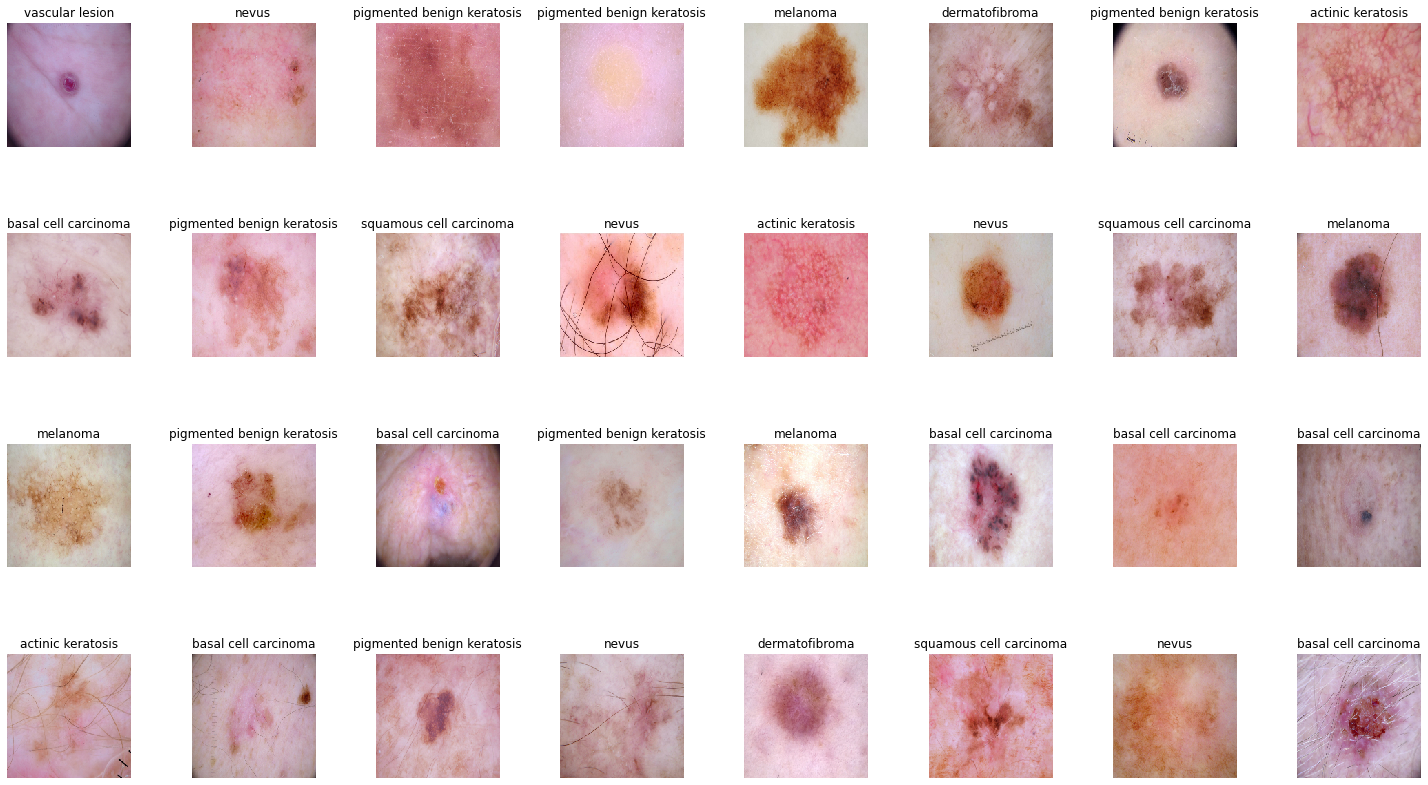

In [19]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(20,12))

for images, labels in train_ds.take(1):
   for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    plt.title(class_names[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"), interpolation='nearest')
    plt.axis("off")
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
### Your code goes here
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,  activation = "softmax")   
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [22]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 481s 2s/step - loss: 1.9630 - accuracy: 0.2974 - val_loss: 1.6919 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6353 - accuracy: 0.4163 - val_loss: 1.5330 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4025 - accuracy: 0.5078 - val_loss: 1.3893 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3077 - accuracy: 0.5530 - val_loss: 1.4833 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2131 - accuracy: 0.5770 - val_loss: 1.4933 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1696 - accuracy: 0.5826 - val_loss: 1.4076 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1111 - accuracy: 0.6027 - val_loss: 1.5135 - val_accuracy: 0.5302
Epoch 8/20
56/56 [======

### Visualizing training results

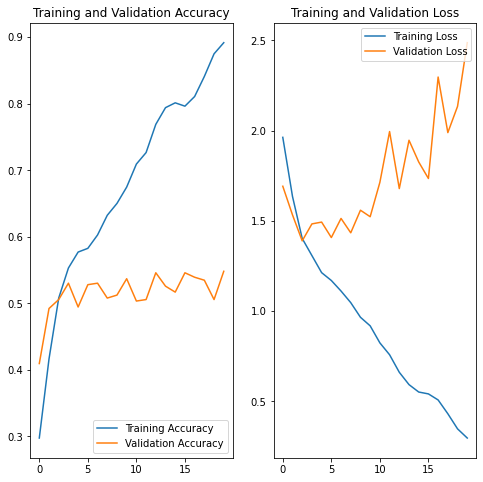

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

#### Training v/s Validation Accuracy Plots
- Training accuracy is increasing linearly till ~89%
- Validation Accuray ~55%
- The difference between training and validation accuracy is noticable. 
#### Traning v/s Validation Loss Plots
- There is also huge gap in Training v/s Validation Loss. 

### Clearly Model is Overfitting

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                  input_shape=(img_height,
                                                               img_width,
                                                               3)),
     layers.experimental.preprocessing.RandomRotation(0.45),
     layers.experimental.preprocessing.RandomZoom(0.5),
     layers.experimental.preprocessing.RandomContrast(0.7),
     layers.experimental.preprocessing.RandomCrop(img_height, img_width),
     layers.experimental.preprocessing.RandomTranslation(0.85,0.75,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    ]
)

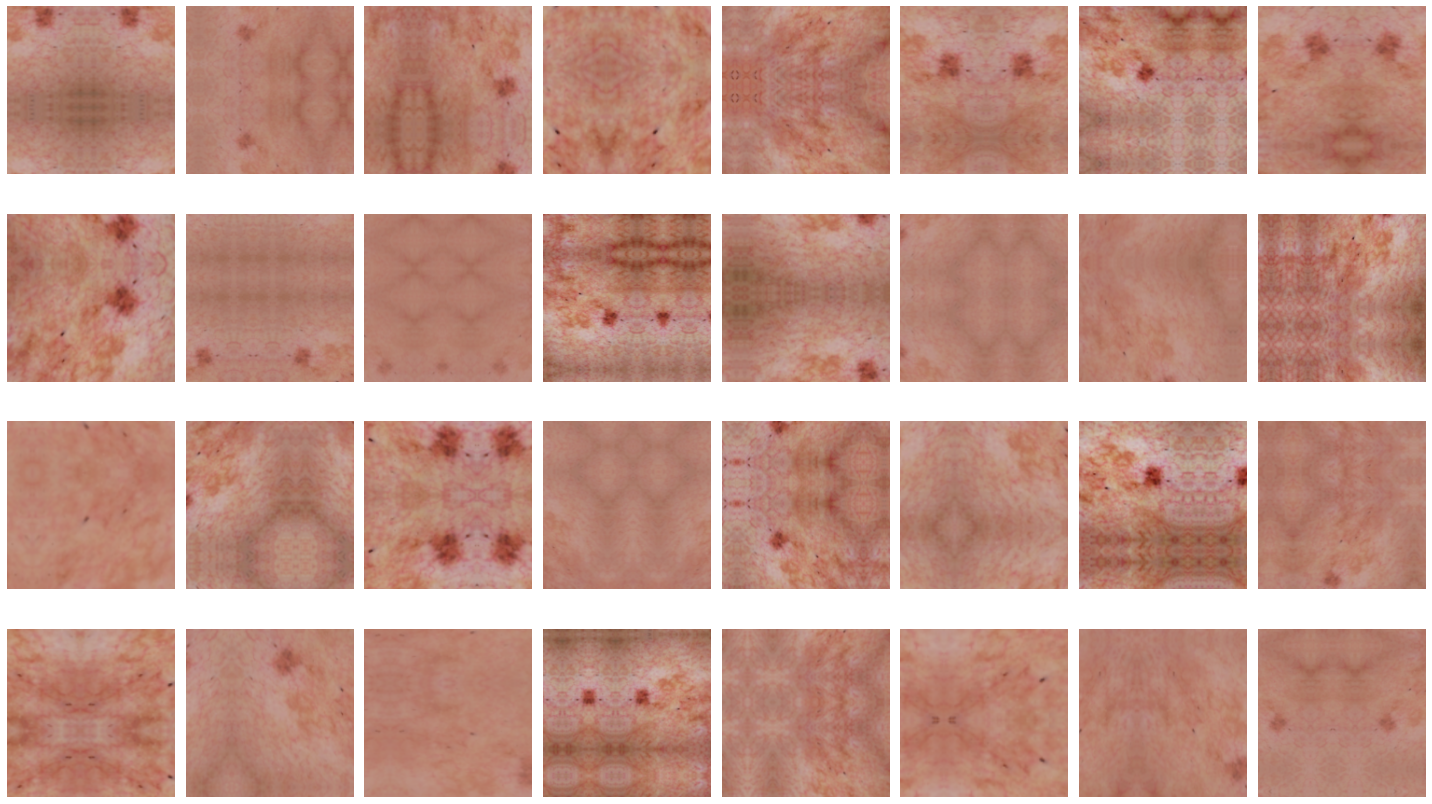

In [27]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(20,12))
for images, _ in train_ds.take(1):  
  for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation = "softmax")
])



### Compiling the model

In [29]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [31]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 40s 522ms/step - loss: 2.6371 - accuracy: 0.1786 - val_loss: 2.1249 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 29s 513ms/step - loss: 2.0312 - accuracy: 0.2015 - val_loss: 2.0546 - val_accuracy: 0.2729
Epoch 3/20
56/56 [==============================] - 29s 513ms/step - loss: 1.9852 - accuracy: 0.2455 - val_loss: 1.9388 - val_accuracy: 0.3110
Epoch 4/20
56/56 [==============================] - 29s 517ms/step - loss: 1.8719 - accuracy: 0.2919 - val_loss: 2.0642 - val_accuracy: 0.2013
Epoch 5/20
56/56 [==============================] - 29s 513ms/step - loss: 1.8399 - accuracy: 0.3192 - val_loss: 1.7413 - val_accuracy: 0.3132
Epoch 6/20
56/56 [==============================] - 29s 527ms/step - loss: 1.7492 - accuracy: 0.3281 - val_loss: 1.7443 - val_accuracy: 0.3691
Epoch 7/20
56/56 [==============================] - 30s 527ms/step - loss: 1.7170 - accuracy: 0.3555 - val_loss: 1.7461 - val_accuracy: 0.3579
Epoch 8/20

### Visualizing the results

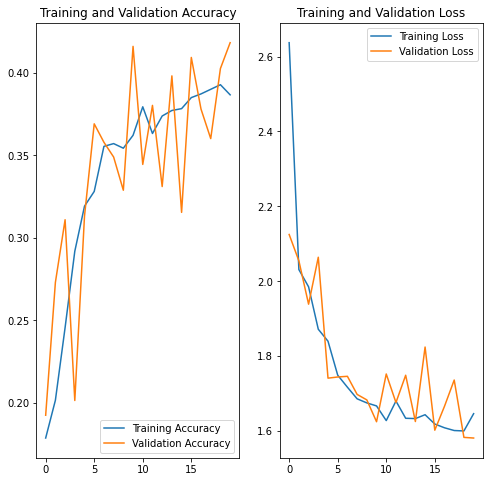

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings

- The Training Accuracy is reduced to ~39%
- Validation Accuracy is ~41% 
- Gap between two is minimum
- The Training & Validation Loss is ~1.6%

### There is some gain in using augmentation as overfitting is not observed now. Model tends to underfit now


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
## Your code goes here.

from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [34]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Upgrad Assignment/Ski...,nevus
1,/content/gdrive/My Drive/Upgrad Assignment/Ski...,nevus
2,/content/gdrive/My Drive/Upgrad Assignment/Ski...,nevus
3,/content/gdrive/My Drive/Upgrad Assignment/Ski...,nevus
4,/content/gdrive/My Drive/Upgrad Assignment/Ski...,nevus
...,...,...
2234,/content/gdrive/My Drive/Upgrad Assignment/Ski...,pigmented benign keratosis
2235,/content/gdrive/My Drive/Upgrad Assignment/Ski...,pigmented benign keratosis
2236,/content/gdrive/My Drive/Upgrad Assignment/Ski...,pigmented benign keratosis
2237,/content/gdrive/My Drive/Upgrad Assignment/Ski...,pigmented benign keratosis


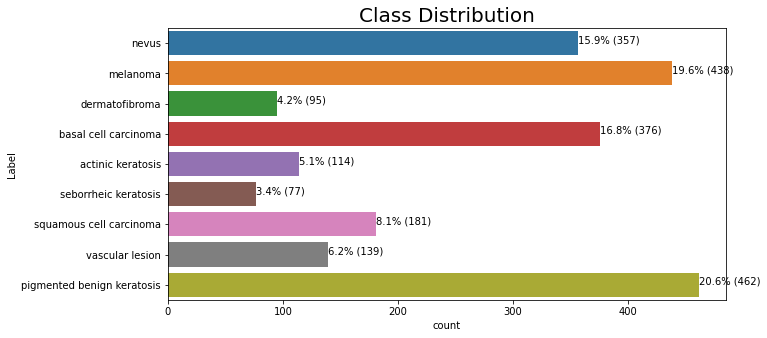

In [36]:
import seaborn as sns
plt.figure(figsize=(10,5))
plt.title('Class Distribution', fontsize=20)
total = float(len(original_df))
ax = sns.countplot(y=original_df['Label'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total) 
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() /2
    ax.annotate('{0} ({1})'.format(percentage,p.get_width()), (x, y))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset='/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F512C0388E0>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F51247D4820>: 100%|██████████| 500/500 [00:21<00:00, 23.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F51247C9880>: 100%|██████████| 500/500 [00:20<00:00, 24.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7F5124783760>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=959x723 at 0x7F512C07CF70>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5124741E50>: 100%|██████████| 500/500 [00:21<00:00, 23.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F512C123040>: 100%|██████████| 500/500 [00:47<00:00, 10.42 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F51247AC520>: 100%|██████████| 500/500 [00:19<00:00, 25.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F512C10E310>: 100%|██████████| 500/500 [00:21<00:00, 23.69 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029141.jpg_f799d0e7-141b-46fb-8e2c-5c5c19c746e0.jpg',
 '/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000243.jpg_fda01ca9-099a-4b7c-865a-6e9c7065147c.jpg',
 '/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000527.jpg_e5981540-7e8f-4a08-9f36-36c9b696c9d9.jpg',
 '/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000240.jpg_e82a5696-933b-4ea8-881c-cc047dfc102a.jpg',
 '/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025803.jpg_e95f741a-421e-42f9-a5e5-678d45be455e.j

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [49]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train="/content/gdrive/My Drive/Upgrad Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation = "softmax")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [57]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 44s 85ms/step - loss: 1.6420 - accuracy: 0.4199 - val_loss: 20.7409 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 7s 41ms/step - loss: 1.1941 - accuracy: 0.5710 - val_loss: 6.7410 - val_accuracy: 0.1707
Epoch 3/30
169/169 [==============================] - 7s 41ms/step - loss: 0.9599 - accuracy: 0.6569 - val_loss: 5.2224 - val_accuracy: 0.3697
Epoch 4/30
169/169 [==============================] - 7s 42ms/step - loss: 0.7460 - accuracy: 0.7417 - val_loss: 2.7397 - val_accuracy: 0.4061
Epoch 5/30
169/169 [==============================] - 7s 41ms/step - loss: 0.5750 - accuracy: 0.7997 - val_loss: 1.1472 - val_accuracy: 0.6340
Epoch 6/30
169/169 [==============================] - 7s 42ms/step - loss: 0.4194 - accuracy: 0.8514 - val_loss: 0.9051 - val_accuracy: 0.7223
Epoch 7/30
169/169 [==============================] - 7s 43ms/step - loss: 0.3024 - accuracy: 0.9019 - val_loss: 1.2644 - val_accuracy: 0.6132
Epoch 8/

#### **Todo:**  Visualize the model results

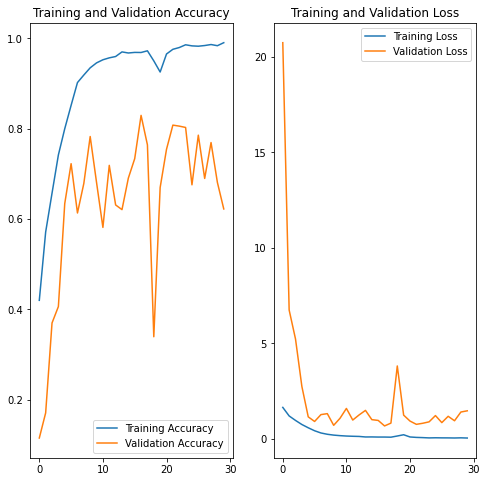

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## Findings
- Training Accuracy is ~99% and Validation accuracy is more than 75% in some epochs.

### Clearly Augmentation and Class rebalance has helped us to get rid of Overfitting and Underfitting



In [59]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  labels='inferred',
  label_mode='int',
  batch_size=32,
  class_names=None,
  color_mode='rgb',
  image_size=(img_height, img_width),
  seed=123,
  shuffle=False,
  interpolation='bilinear',
  follow_links=False)

Found 118 files belonging to 9 classes.


## Augmentation and Class rebalance has helped us to get rid of Overfitting and Underfitting